In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def simu_samp(n_samp=40, n_features=100, d=0.5):
    # Simulate some Gaussian data with controlled deviation from 0
    return np.random.normal(d, 1, [n_samp, n_features])        

def generate_beta(samp):
    # Generate beta estimates (here a simple mean)
    return np.mean(samp, axis=0)
    
def percentile_beta(beta, percentile=0.9):
    # Extract a given percentile of the distribution of beta estimates 
    # across features
    beta = np.sort(beta)
    beta_percentile = beta[int(np.ceil(percentile * beta.shape[0]))]
    return beta_percentile

def effect_size_split(samp, percentile=0.9):
    n_samp = int(np.ceil(samp.shape[0] / 2))
    mean_train = np.mean(samp[0:n_samp, :], axis=0)
    idx = np.argsort(mean_train)
    idx = idx[int(np.ceil(percentile * samp.shape[1])):-1]
    mean_test = np.mean(samp[n_samp:, :], axis=0)
    
    return np.mean(mean_test[idx])

def effect_size_split_bootstrap(samp, percentile=0.9):
    n_samp = int(np.ceil(samp.shape[0] / 2))
    mean_train = np.mean(bootstrap_samp(samp[0:n_samp, :]), axis=0)
    idx = np.argsort(mean_train)
    idx = idx[int(np.ceil(percentile * samp.shape[1])):-1]
    mean_test = np.mean(bootstrap_samp(samp[n_samp:, :]), axis=0)
    
    return np.mean(mean_test[idx])

def bootstrap_samp(samp):
    # Bootstrap Gaussian data across samples
    idx = range(samp.shape[0])
    resample_idx = np.random.choice(idx, len(idx))
    return samp[resample_idx, :]

# Original vs bootstrap betas 

Here we simulate Gaussian data, with a non-zero mean and unit variance. The number of samples (`n_samp`) would correspond to the number of subjects (from, say, 40 to a few thousands). This simulation is repeated for a number of features (`n_features`), which would correspond to the different functional connectivity measures. We compare the distribution of sample mean in the original sample to the mean generated from bootstrap samples. We notice that the bootstrap means have more variance. This is because each bootstrap sample re-uses only a substet of the original observations (which size varies across subsets). So in practice, we are generating sample means with a smaller sample size. 

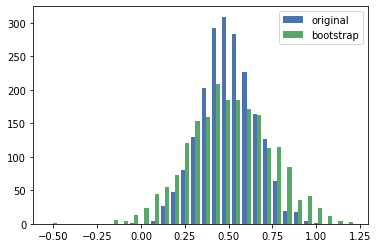

In [3]:
# Simulation parameters
n_samp = 40
n_features = 2000
d = 0.5

# Generate original beta values
samp = simu_samp(n_samp, n_features, d)
beta = generate_beta(samp)

# Generate replicated bootstrap values 
samp_bootstrap = bootstrap_samp(samp)
beta_bootstrap = generate_beta(samp_bootstrap)

# Show histogram of original vs bootstrap beta values
plt.style.use('seaborn-deep')
plt.hist([beta, beta_bootstrap], label=['original', 'bootstrap'], bins=30)
plt.legend(loc='upper right')
plt.show()

# Top 10th percentile of effect estimates
We now suppose we are going to sort the features and only retain the top 10th percentile of the means. We are going to repeat many simulations like the one above to get a distribution on the 10th-percentiles for the original samples vs the bootstrap samples. 

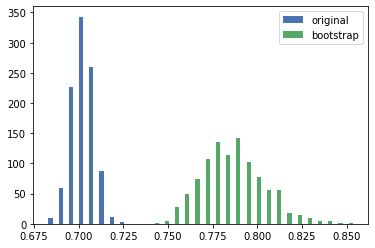

average effect size estimate 0.7030507092896316 (original sample) and 0.7856454076660027 (bootstrap)


In [4]:
n_simu = 1000
beta_90 = []
beta_bootstrap_90 = []

# Repeat simulations and retain top 10th percentile of betas 
for simu in range(n_simu):
    samp = simu_samp(n_samp, n_features, d)
    beta_90.append(percentile_beta(generate_beta(samp)))
    beta_bootstrap_90.append(percentile_beta(generate_beta(bootstrap_samp(samp))))

# Show histogram of original vs bootstrap beta values
plt.style.use('seaborn-deep')
plt.hist([beta_90, beta_bootstrap_90], label=['original', 'bootstrap'], bins=30)
plt.legend(loc='upper right')
plt.show()

# report 
print(f'average effect size estimate {np.mean(beta_90)} (original sample) and {np.mean(beta_bootstrap_90)} (bootstrap)')

As the bootstrap distribution is wider (more variance), we can observe that the 10th percentile in the bootstrap distribution is almost systematically larger than in the original sample. More importantly, we can see that the original distribution is centered around 0.7, much larger than our true effect size of 0.5. This is because of **double dipping**: we use the same data to select the features with large effects, and quantify the effect size. This bias gets larger when the sample size is small (because the effect size estimate is more variable, so more leverage to find inflated estimates) and when the number of features is large (because we have many attempts to find inflated estimates). 

# Split half cross-validated effect sizes - Naive bootstrap

The bias in effect size estimates is a reflection of a size in the variance of the bootstrap of the distribution, itself related to differences in sample size. But at the core this bias should not be here. And it is only present because we are selecting features and estimationg effect sizes on the same sample. Let's try to replace the naive approach and use split-half cross-validation to identify the top tenth percentile features and the effect size on separate datasets. We'll apply the same approach on the original samples and the bootstrap samples.

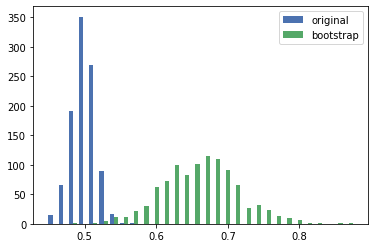

average effect size estimate 0.49999519274831605 (original sample) and 0.6610248839988563 (bootstrap)


In [5]:
n_simu = 1000
beta_90 = []
beta_bootstrap_90 = []

# Repeat simulations and retain top 10th percentile of betas 
for simu in range(n_simu):
    samp = simu_samp(n_samp, n_features, d)
    beta_90.append(effect_size_split(samp))
    beta_bootstrap_90.append(effect_size_split(bootstrap_samp(samp)))

# Show histogram of original vs bootstrap beta values
plt.style.use('seaborn-deep')
plt.hist([beta_90, beta_bootstrap_90], label=['original', 'bootstrap'], bins=30)
plt.legend(loc='upper right')
plt.show()

# report 
print(f'average effect size estimate {np.mean(beta_90)} (original sample) and {np.mean(beta_bootstrap_90)} (bootstrap)')

The original estimator is now unbiased (YAY). We see a moderate increase in the variance of our effect size estimate. This is normal, because we're only using half of the sample size for this estimation now... There is still a bias with bootstrap though, although much smaller. This is due to **leakage**. The bootstrap is performed prior to cross-validation, so there are shared data points in our train and test sample. Which means that the selection we do of features is not independent of the effect size. 

# Split half cross-validated effect sizes - Stratified bootstrap

Let's redo the experiment above, but this time we are going to apply the bootstrap **separately in the training and test sets**. This way we're going to properly quantify the variability both of the feature selection process and the effect size estimation, but we will not create leakage between training and testing.

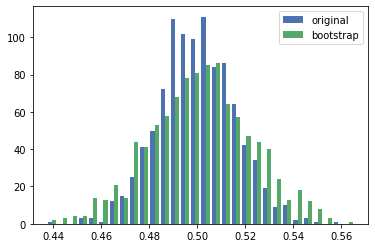

average effect size estimate 0.49998821347669464 (original sample) and 0.5011635859171568 (bootstrap)


In [6]:
n_simu = 1000
beta_90 = []
beta_bootstrap_90 = []

# Repeat simulations and retain top 10th percentile of betas 
for simu in range(n_simu):
    samp = simu_samp(n_samp, n_features, d)
    beta_90.append(effect_size_split(samp))
    beta_bootstrap_90.append(effect_size_split_bootstrap(samp))

# Show histogram of original vs bootstrap beta values
plt.style.use('seaborn-deep')
plt.hist([beta_90, beta_bootstrap_90], label=['original', 'bootstrap'], bins=30)
plt.legend(loc='upper right')
plt.show()

# report 
print(f'average effect size estimate {np.mean(beta_90)} (original sample) and {np.mean(beta_bootstrap_90)} (bootstrap)')